In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [2]:
from radial.dataset import Dataset, FilesIndex, Pipeline, action, inbatch_parallel, B, V, C
import radial.dataset as ds
from radial.dataset.models.tf import TFModel, VGG7
from radial import RadialBatch

In [3]:
GRID_SIZE = 200

In [4]:
class TmpBatch(RadialBatch):
    components = 'time', 'derivative', 'rig_type', 'target', 'time_grid', 'derivative_grid', 'norm_time', 'predictions'
    def __init__(self, index, preloaded=None):
        super().__init__(index, preloaded)
        self.time = self.array_of_nones
        self.derivative = self.array_of_nones
        self.rig_type = self.array_of_nones
        self.target = self.array_of_nones
        self.time_grid = self.array_of_nones
        self.derivative_grid = self.array_of_nones
        self.norm_time = self.array_of_nones
        self.derivative_range = self.array_of_nones
        self.predictions = self.array_of_nones
        
    @action
    @inbatch_parallel(init='indices')
    def normalize_derivative(self, ix, src='derivative', dst=None):
        dst = src if dst is None else dst
        
        comp_data = self.get(ix, src)
        pos = self.get_pos(None, src, ix)
        
        new_data = (comp_data - np.min(comp_data)) / (np.max(comp_data) - np.min(comp_data))
        getattr(self, dst)[pos] = new_data
                
        new_target = (self.get(ix, 'target') - np.min(comp_data)) / (np.max(comp_data) - np.min(comp_data))
        getattr(self, 'target')[pos] = new_target
        getattr(self, 'derivative_range')[pos] = [np.min(comp_data), np.max(comp_data) - np.min(comp_data)]
        
        return self

    
    @action
    @inbatch_parallel(init='indices')
    def normalize_component(self, ix, src='time', dst=None):
        dst = src if dst is None else dst
        
        comp_data = self.get(ix, src)
        pos = self.get_pos(None, src, ix)
        
        new_data = (comp_data - np.min(comp_data)) / (np.max(comp_data) - np.min(comp_data))
        getattr(self, dst)[pos] = new_data
        return self

    
    @action
    @inbatch_parallel(init='indices', post='_assemble', components=('time_grid', 'derivative_grid'))
    def make_grid_data(self, ix, grid_size=500):
        time = self.get(ix, 'norm_time')
        dp = self.get(ix, 'derivative')
        sorted_data = list(zip(*sorted(zip(time, dp), key=lambda x: x[0])))
        grid = np.linspace(0, 1, num=grid_size)
        dp_grid = np.interp(grid, sorted_data[0], sorted_data[1])
        return (grid, dp_grid.reshape((-1, 1)))

    
    @action
    def reshape_target(self):
        self.target = self.target.reshape((-1, 1))
        return self 

# Загрузка данных

In [5]:
path = 'npz/*.npz'
index = FilesIndex(path=path, no_ext=True)
ds = Dataset(index, batch_class=TmpBatch)
ds.split(0.1)

    В качестве препроцессинга приведем время, производную давления к значениям в [0, 1].
    Таргет также нормируем по формуле $(target - min(derivative)) / (max(derivative) - min(derivative))$

    Для того, чтобы на вход сетки приходили данные одной размерности, кусочно интерполируем производную и возьмем значения по равномерной сетке размера GRID_SIZE.

In [6]:
load_ppl = (Pipeline()
            .load(fmt='npz', components=['time', 'derivative', 'rig_type', 'target'])
            .normalize_component(src='time', dst='norm_time')
            .normalize_derivative(src='derivative')
            .make_grid_data(grid_size=GRID_SIZE)
            .reshape_target()
           )

# Визуализация данных

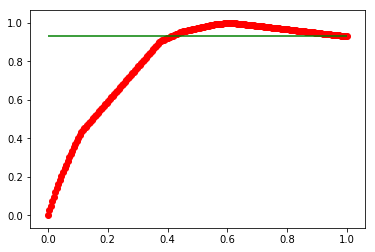

----------------------


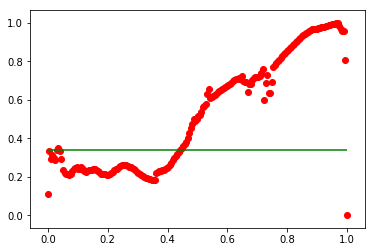

----------------------


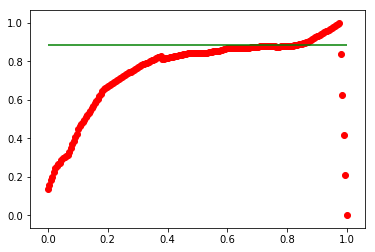

----------------------


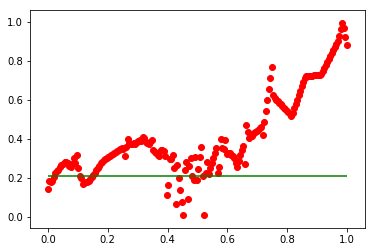

----------------------


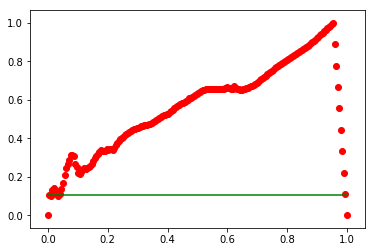

----------------------


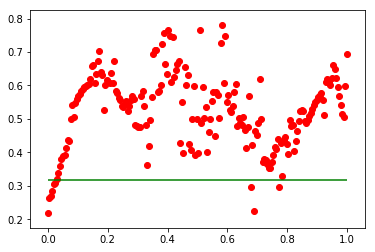

----------------------


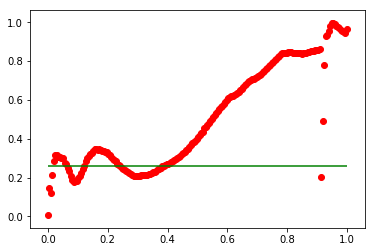

----------------------


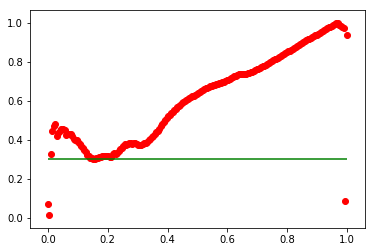

----------------------


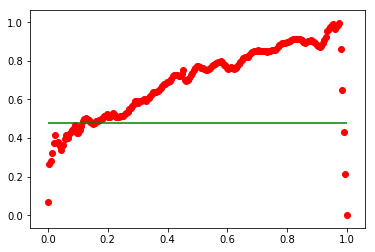

----------------------


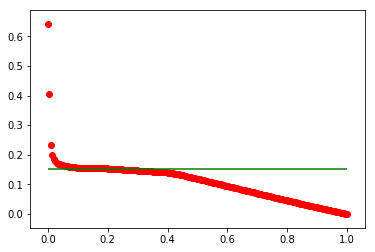

----------------------


In [7]:
for i in range(10):
    btch = (load_ppl << ds).next_batch(2)
#     plt.scatter(btch.time[0], btch.derivative[0])
#     plt.hlines(btch.target[0], 0, np.max(btch.time[0]), colors='g')
#     plt.show()

#     plt.scatter(btch.norm_time[0], btch.derivative[0])
    plt.scatter(btch.time_grid[0], btch.derivative_grid[0], c='r')
    plt.hlines(btch.target[0], 0, 1, colors='g')
    plt.show()
    print('----------------------')

# Обучение модели

Обучим небольшую сетку с 2 слоями одномерных сверток с ядром 20

На вход сети подаем одномерный массив производных размера (GRID_SIZE, 1)

In [1253]:
model_config={'inputs': dict(signals={'shape': (GRID_SIZE, 1)},
                             labels={'shape': (1, ), 'name': 'targets'}),
              'body': dict(layout='cnacna', kernel_size=[20, 20], filters=[10, 10]),
              'head': dict(layout='fa', units=1),
              'initial_block/inputs': 'signals',
              'loss': 'mse',
              'optimizer': ('MomentumOptimizer', {'learning_rate': 0.001, 'momentum': 0.5}),
             }

In [1291]:
train_template = (load_ppl
                  .init_variable('loss', init_on_each_run=0)
                  .init_variable('predictions', init_on_each_run=0)
                  .init_variable('saved_targets', init_on_each_run=0)
                  .init_variable('saved_indices', init_on_each_run=0)
                  .init_model('static', TFModel, 'baseline', config=model_config)
                  .train_model('baseline', fetches=['loss', 'predictions'],
                               feed_dict={'signals': B('derivative_grid'),
                                          'labels': B('target')},
                               save_to=[V('loss'), V('predictions')], mode='w')
                  .update_variable('saved_targets', B('target'))
                  .update_variable('saved_indices', B('indices'))
                 ) << ds.train

test_template = (load_ppl
                  .init_variable('loss', init_on_each_run=0)
                  .init_variable('predictions', init_on_each_run=0)
                  .init_variable('saved_targets', init_on_each_run=0)
                  .init_variable('saved_indices', init_on_each_run=0)
                  .import_model('baseline', train_template)
                  .predict_model('baseline', fetches=['loss', 'predictions'],
                               feed_dict={'signals': B('derivative_grid'),
                                          'labels': B('target')}, 
                                        save_to=[V('loss'), V('predictions')], mode='w')
                  .update_variable('saved_targets', B('target'))
                  .update_variable('saved_indices', B('indices'))
                ) << ds.test

In [1292]:
train_loss = []
test_loss = []

all_targets = []
all_predictions = []
all_indices = []

test_targets = []
test_predictions = []
test_indices = []

In [1293]:
for i in tqdm(range(1000)):
    btch = train_template.next_batch(20, shuffle=True, n_epochs=None, drop_last=True)
    train_loss.append(train_template.get_variable('loss'))
    all_targets.append(train_template.get_variable('saved_targets'))
    all_predictions.append(train_template.get_variable('predictions'))
    all_indices.append(train_template.get_variable('saved_indices'))
    if i % 10 == 0:
        btch = test_template.next_batch(60, shuffle=True, n_epochs=None)
        test_loss.append(test_template.get_variable('loss'))
        test_targets.append(test_template.get_variable('saved_targets'))
        test_predictions.append(test_template.get_variable('predictions'))
        test_indices.append(test_template.get_variable('saved_indices'))

В качестве proof of concept переобучимся на сабсете

** потерянный график лосса

Работает! а теперь обучимся на большей части и провалидируемся на тесте:

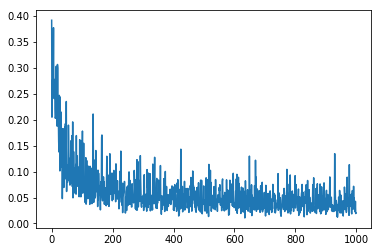

In [1294]:
plt.plot(train_loss)

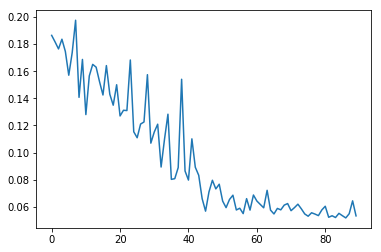

In [1299]:
plt.plot(test_loss[-90:])

# Обработка результатов

In [1296]:
btch = test_template.next_batch(60, shuffle=True, n_epochs=None)
test_loss.append(test_template.get_variable('loss'))
test_targets.append(test_template.get_variable('saved_targets'))
test_predictions.append(test_template.get_variable('predictions'))
test_indices.append(test_template.get_variable('saved_indices'))

In [1297]:
predictions = test_predictions[-1]
targets = test_targets[-1]
btch.derivative_grid.shape


(55, 200, 1)

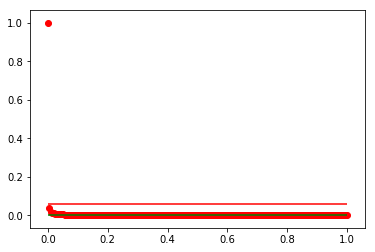

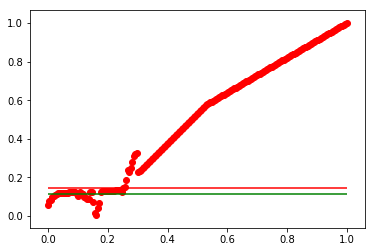

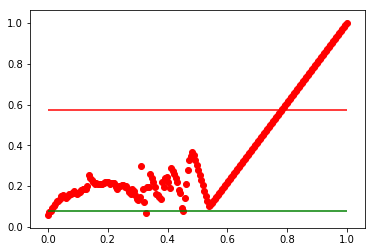

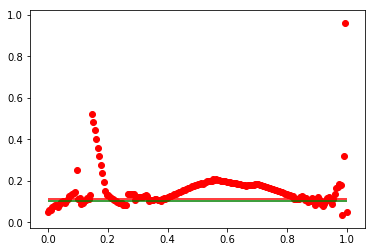

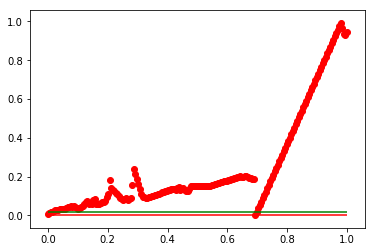

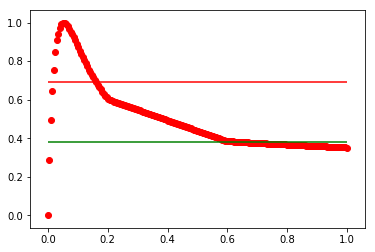

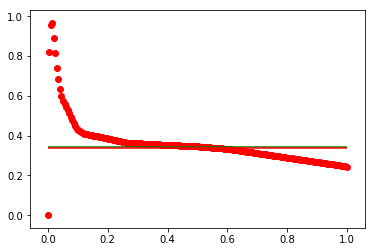

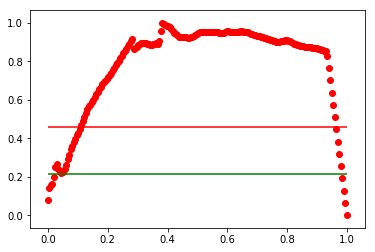

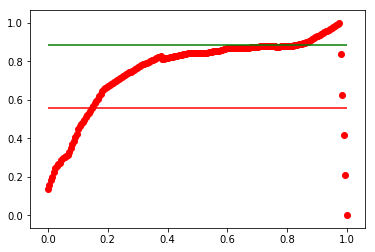

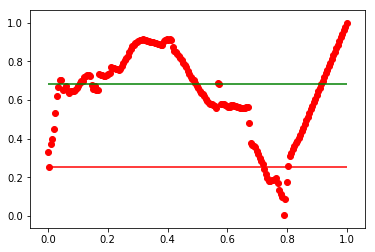

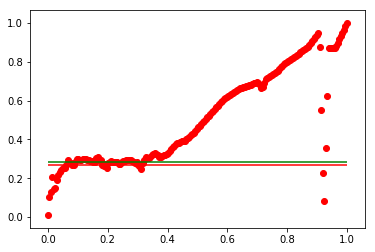

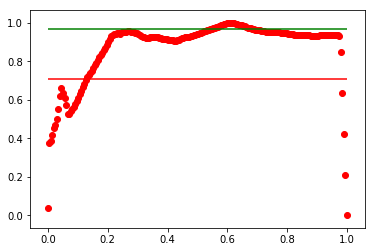

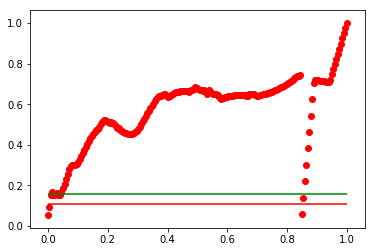

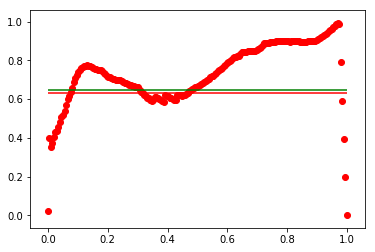

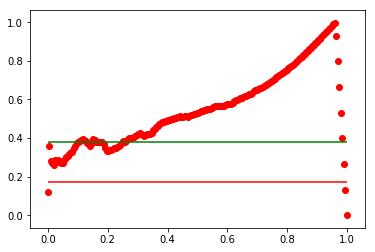

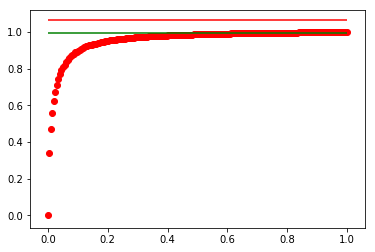

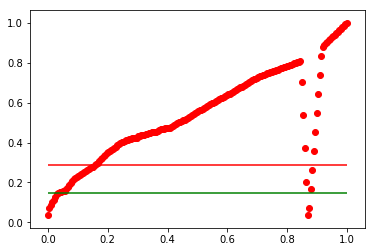

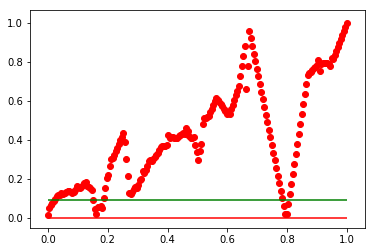

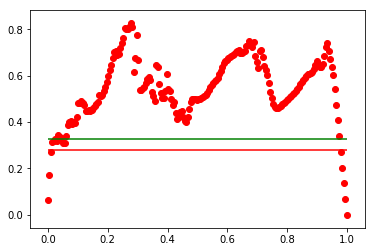

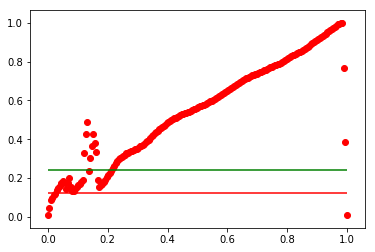

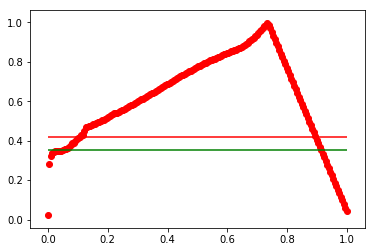

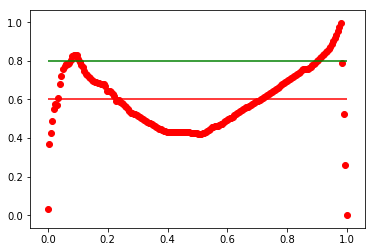

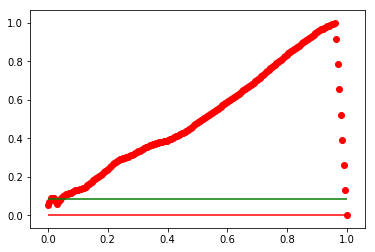

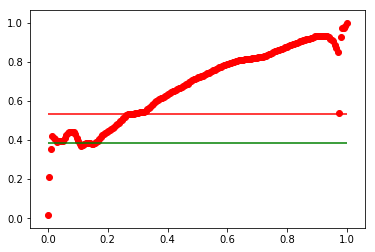

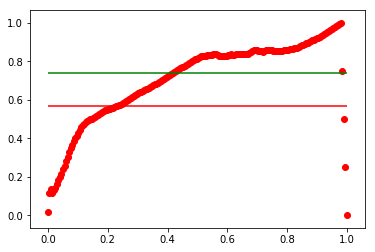

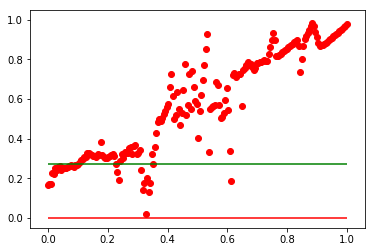

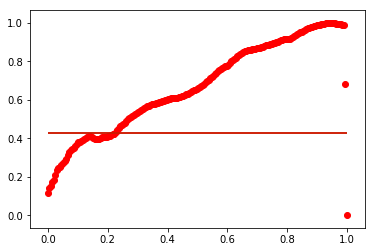

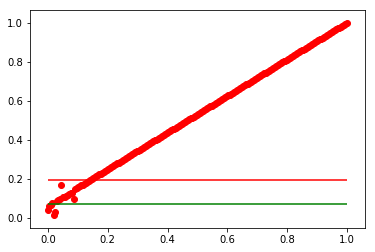

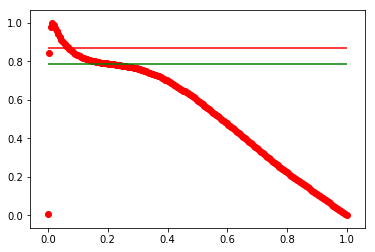

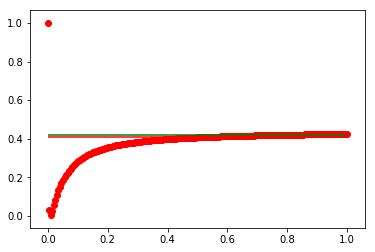

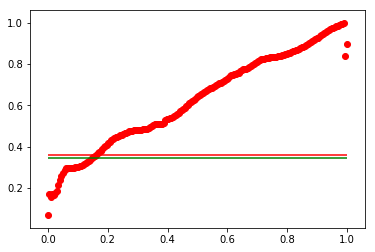

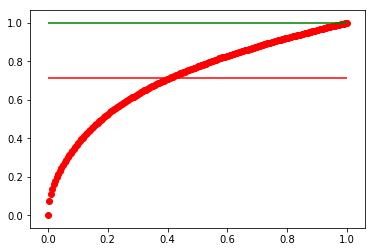

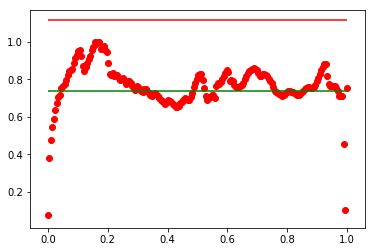

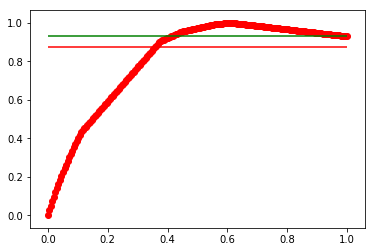

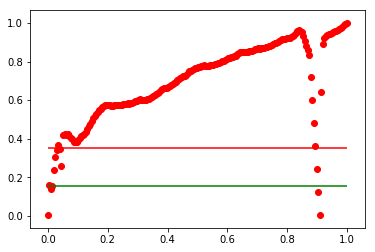

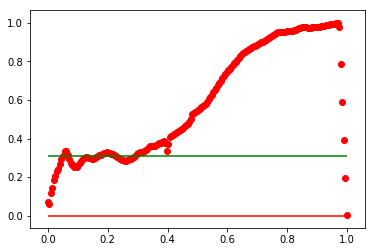

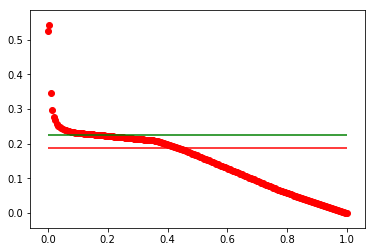

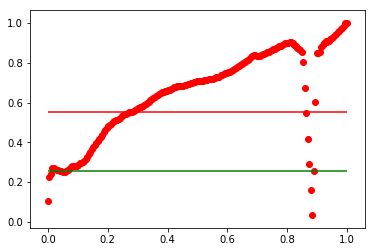

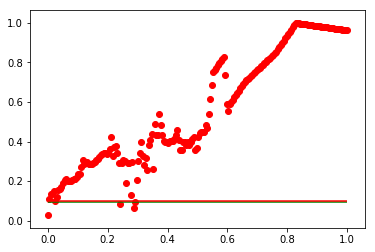

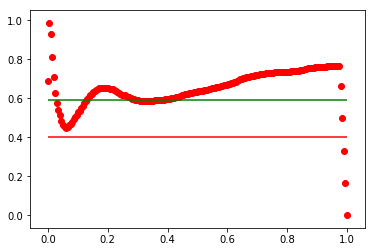

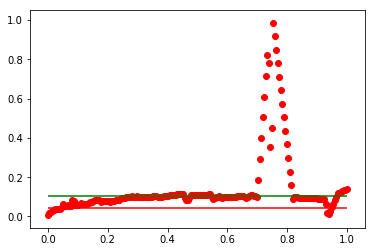

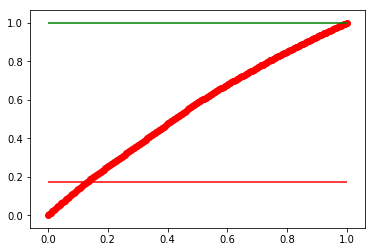

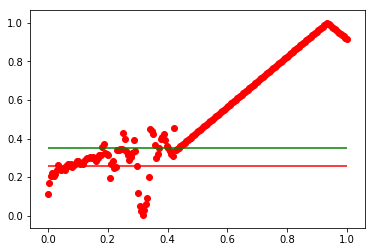

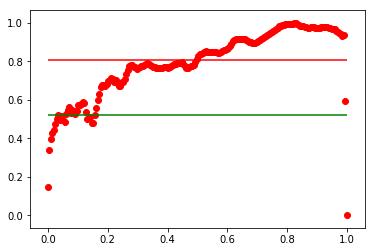

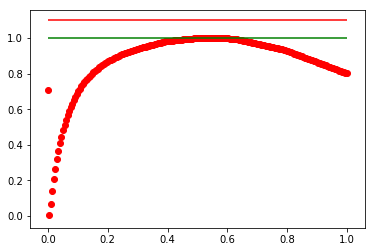

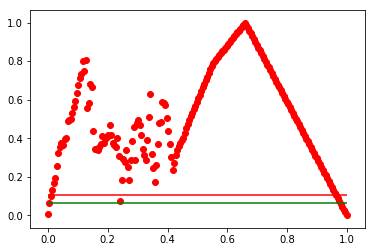

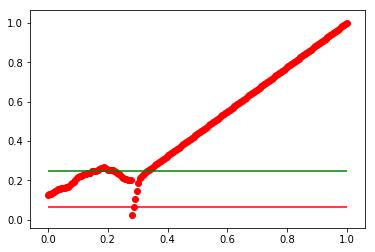

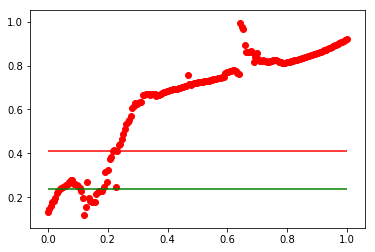

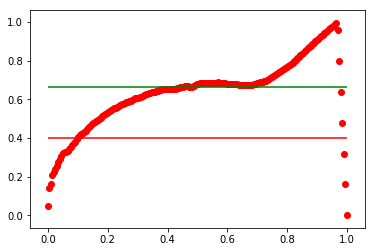

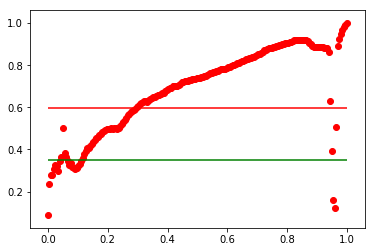

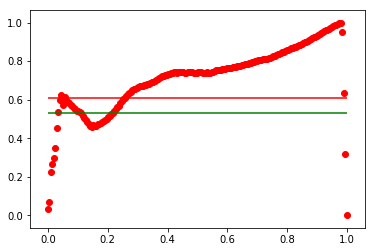

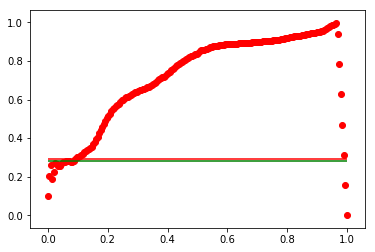

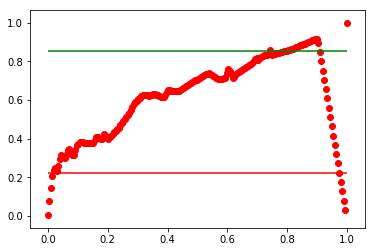

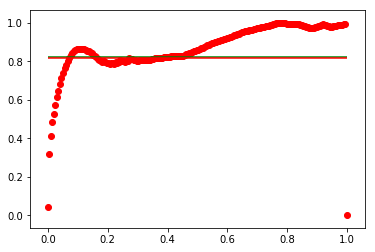

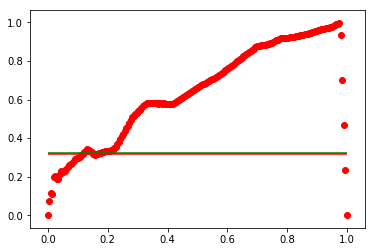

In [1298]:
for i in range(55):
    plt.scatter(btch.time_grid[i], btch.derivative_grid[i], c='r')
    plt.hlines(targets[i], 0, 1, colors='g')
    plt.hlines(predictions[i], 0, 1, colors='r')
    plt.show()

# Критика модели

Среднее отклонение на тесте 0.2 - такое себе результат. 

Но прежде чем начать перебор архитектур, сосредоточимся на препроцессинге

Модель обучалась на сырых данных и после удаления явных выбросов возможно будет работать лучше